# Configuración del entorno

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/InteligenciaComputacional/codigo/

/content/drive/My Drive/InteligenciaComputacional/codigo


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

# Lectura de datos de entrenamiento

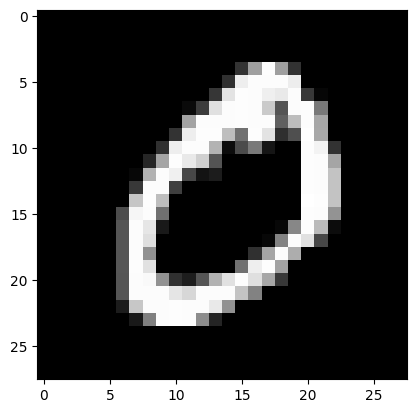

In [5]:

# Ejemplo de lectura de MNIST (imágenes). Leer archivo en binario
f = open('./../datos/train-images-idx3-ubyte/train-images.idx3-ubyte', 'rb')

# Descartar cabecera (16 bytes)
f.read(16)

# El resto de datos son las imágenes.
# La intensidad en escala de grises para cada píxel se guarda en un byte
# Las imágenes son de 28 * 28 por lo que ocupan 784 bytes adyacentes
images = []
while True:
    # Leemos la siguiente imagen
    image = f.read(784)
    if len(image) != 784: # Si no queda imagen parar
        break
    else: # Conversión de binario a entero
        images.append([x for x in image])

# Conversión a array de NumPy
images = np.array(images)

# Muestra por pantalla el primer número para comprobar
plt.imshow(images[1].reshape(28,28), cmap='gray')

In [6]:
# Lectura de etiquetas
f = open('../datos/train-labels-idx1-ubyte/train-labels.idx1-ubyte', 'rb')

# Descartar cabecera (8 bytes)
f.read(8)

# El resto de datos son las etiquetas. Cada etiqueta es un byte
etiquetas = np.array([x for x in f.read()])
print(etiquetas)

[5 0 4 ... 5 6 8]


## Datos para test

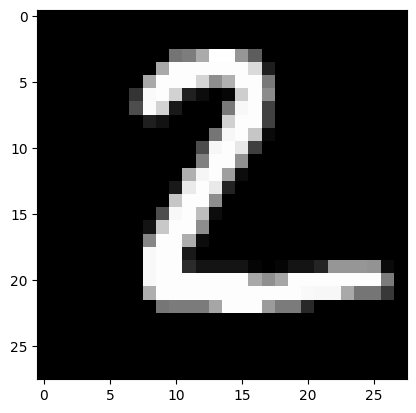

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# Ejemplo de lectura de MNIST (imágenes). Leer archivo en binario
f_test = open('./../datos/t10k-images-idx3-ubyte/t10k-images.idx3-ubyte', 'rb')

# Descartar cabecera (16 bytes)
f_test.read(16)

# El resto de datos son las imágenes.
# La intensidad en escala de grises para cada píxel se guarda en un byte
# Las imágenes son de 28 * 28 por lo que ocupan 784 bytes adyacentes
images_test = []
while True:
    # Leemos la siguiente imagen
    image = f_test.read(784)
    if len(image) != 784: # Si no queda imagen parar
        break
    else: # Conversión de binario a entero
        images_test.append([x for x in image])

# Conversión a array de NumPy
images_test = np.array(images_test)

# Muestra por pantalla el primer número para comprobar
plt.imshow(images_test[1].reshape(28,28), cmap='gray')

In [8]:
# Lectura de etiquetas
f = open('../datos/t10k-labels-idx1-ubyte/t10k-labels.idx1-ubyte', 'rb')

# Descartar cabecera (8 bytes)
f.read(8)

# El resto de datos son las etiquetas. Cada etiqueta es un byte
etiquetas_test = np.array([x for x in f.read()])
print(etiquetas_test)
#print(etiquetas_test.shape)

[7 2 1 ... 4 5 6]


# Preparación de los datos

In [9]:
# Normalizar imágenes
images = images / 255.0
images_test = images_test / 255.0

In [10]:
# Cambiar la forma de las imágenes para usar redes convolutivas (28x28x1)
images = images.reshape(-1, 28, 28, 1)
images_test = images_test.reshape(-1, 28, 28, 1)

# Convertir etiquetas a one-hot encoding
etiquetas = tf.keras.utils.to_categorical(etiquetas, num_classes=10)

# Aumento de datos
Para mejorar la capacidad de generalización del modelo, generamos imágenes aumentadas aplicando rotaciones, desplazamientos, y zoom. Posteriormente, concatenamos las imágenes originales con las imágenes aumentadas para entrenar con un conjunto de datos más amplio.



In [11]:
# Crear un generador de datos para generar nuevas imágenes
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotar hasta 20 grados
    width_shift_range=0.15,   # Desplazar horizontalmente hasta un 15%
    height_shift_range=0.15,  # Desplazar verticalmente hasta un 15%
    zoom_range=0.2           # Aplicar zoom hasta un 20%
)

# Ajustar el generador a los datos iniciales
datagen.fit(images)

# Generar nuevas imágenes
n_images_to_generate = len(images)  # Duplicar el tamaño
generated_images = []
generated_labels = []

for x, y in datagen.flow(images, etiquetas, batch_size=1):
    generated_images.append(x[0])  # Extraer imagen generada
    generated_labels.append(y[0])  # Extraer etiqueta correspondiente

    if len(generated_images) >= n_images_to_generate:
        break

# Convertir a arrays NumPy
generated_images = np.array(generated_images)
generated_labels = np.array(generated_labels)

# Concatenar datos originales y generados
images_augmented = np.concatenate((images, generated_images), axis=0)
etiquetas_augmented = np.concatenate((etiquetas, generated_labels), axis=0)

# Construcción del modelo

A continuación se define una red neuronal convolucional con regularización L2 para evitar sobreajuste, batch normalization para estabilizar el entrenamiento y dropout para mejorar la generalización.

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow.keras.regularizers as regularizers

# Ajustamos la regularización L2 (más suave)
weight_decay = 1e-5

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(10, activation='softmax')
])

# Callbacks

Se configura un callback ReduceLROnPlateau para disminuir el learning rate cuando el modelo deja de mejorar.

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Definir el callback para reducir el learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Métrica a monitorear
    factor=0.5,             # Multiplicar el learning rate por este factor
    patience=4,             # Número de épocas sin mejora antes de reducir el learning rate
    min_lr=1e-6,            # Valor mínimo del learning rate
    verbose=1               # Mostrar mensaje cuando se reduzca el learning rate
)


# Compilación y entrenamiento del modelo
 Compilamos el modelo con el optimizador Adam y la función de pérdida categorical_crossentropy y a continuación entrenamos el modelo con el conjunto de datos aumentado.

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
model.fit(images_augmented, etiquetas_augmented, epochs=75, batch_size=64, validation_split=0.1, callbacks=[reduce_lr])
end_time = time.time()

Epoch 1/75
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.8533 - loss: 0.4905 - val_accuracy: 0.9597 - val_loss: 0.1518 - learning_rate: 0.0010
Epoch 2/75
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9711 - loss: 0.1154 - val_accuracy: 0.9646 - val_loss: 0.1366 - learning_rate: 0.0010
Epoch 3/75
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9794 - loss: 0.0925 - val_accuracy: 0.9682 - val_loss: 0.1396 - learning_rate: 0.0010
Epoch 4/75
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9828 - loss: 0.0892 - val_accuracy: 0.9686 - val_loss: 0.1451 - learning_rate: 0.0010
Epoch 5/75
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9851 - loss: 0.0893 - val_accuracy: 0.9768 - val_loss: 0.1234 - learning_rate: 0.0010
Epoch 6/75
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9872 - loss: 0.0868 - val_accuracy: 0.9785 - val_loss: 0.1215 - learning_rate: 0.0010
Epoch 7/75
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.

In [15]:
print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")

Tiempo de entrenamiento: 1275.2312047481537 segundos


# Evaluación del modelo

### Primero con los mismos datos de entrenamiento

In [16]:
from sklearn.metrics import accuracy_score
preds_train = model.predict(images_augmented).argmax(axis=1)

acc = accuracy_score(etiquetas_augmented.argmax(axis=1), preds_train)
print("Precisión: ", acc*100, "%, Tasa de error: ", 100 - acc*100 ,"%")



3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Precisión:  99.87 %, Tasa de error:  0.12999999999999545 %


### Ahora con los datos para test

In [17]:
preds_test = model.predict(images_test).argmax(axis=1)
print (preds_test)
print (preds_train)

acc_test = accuracy_score(etiquetas_test, preds_test)
print("Precisión: ", acc_test*100, "%, Tasa de error: ", 100 - acc_test*100, "%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[7 2 1 ... 4 5 6]
[5 0 4 ... 8 3 7]
Precisión:  99.68 %, Tasa de error:  0.3199999999999932 %


0.379%

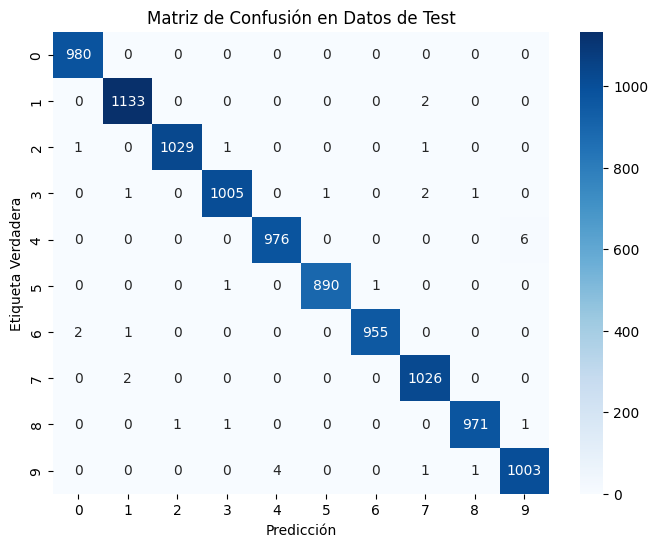

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generar la matriz de confusión
conf_matrix = confusion_matrix(etiquetas_test, preds_test)

# Crear un mapa de calor para visualizar la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusión en Datos de Test')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()


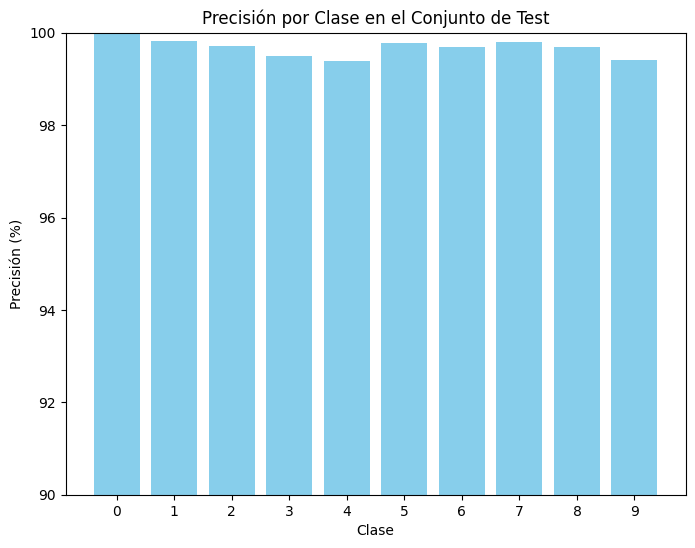

In [19]:
# Calcular la precisión por clase
import numpy as np

precisiones_por_clase = []
for clase in range(10):
    idx = np.where(etiquetas_test == clase)
    acc_clase = accuracy_score(etiquetas_test[idx], preds_test[idx])
    precisiones_por_clase.append(acc_clase * 100)

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(range(10), precisiones_por_clase, color='skyblue')
plt.title('Precisión por Clase en el Conjunto de Test')
plt.xlabel('Clase')
plt.ylabel('Precisión (%)')
plt.xticks(range(10))
plt.ylim(90, 100)  # Ajustar límites para facilitar la comparación
plt.show()


In [20]:
from google.colab import runtime
runtime.unassign()